In [ ]:
# Set seed for reproducibility
seed = 42

import random
from datetime import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy as scc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
import cv2

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 🪨 Load and prepare data

In [ ]:
data = np.load("clean_dataset.npz")
X = data["images"]
y = data["labels"]

data = np.load("mars_for_students.npz")
X_test = data["test_set"]

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (2004, 64, 128)
Validation set shape: (501, 64, 128)
Test set shape: (10022, 64, 128)


In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

X_train shape: (2004, 64, 128, 1)
y_train shape: (2004, 64, 128)
X_val shape: (501, 64, 128, 1)
Input shape: (64, 128, 1)
Number of classes: 5


# 📝 Define Losses


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(y_pred)[-1])  # One-hot encode ground truth
    y_pred = tf.nn.softmax(y_pred, axis=-1)  # Apply softmax to predictions

    intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true_one_hot, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return 1 - tf.reduce_mean(dice)

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2.0):

    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(y_pred)[-1])  # One-hot encode ground truth
    y_pred = tf.nn.softmax(y_pred, axis=-1)  # Apply softmax to predictions

    pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)  # Probability of the true class
    focal_loss_value = -alpha * ((1 - pt) ** gamma) * tf.math.log(pt + 1e-6)

    return tf.reduce_mean(focal_loss_value)

def boundary_loss(y_true, y_pred, smooth=1e-6):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(y_pred)[-1])  # One-hot encode
    y_pred = tf.nn.softmax(y_pred, axis=-1)  # Apply softmax to predictions

    # Compute gradients for boundaries (Sobel filters)
    y_true_edges = tf.image.sobel_edges(tf.cast(y_true_one_hot, tf.float32))
    y_pred_edges = tf.image.sobel_edges(tf.cast(y_pred, tf.float32))

    y_true_edges_magnitude = tf.reduce_sum(tf.square(y_true_edges), axis=-1)
    y_pred_edges_magnitude = tf.reduce_sum(tf.square(y_pred_edges), axis=-1)

    boundary_loss_value = tf.reduce_mean((y_true_edges_magnitude - y_pred_edges_magnitude) ** 2)
    return boundary_loss_value

def combined_loss(y_true, y_pred, weight_dice=0.3, weight_focal=0.4, weight_boundary=0.3):
  loss = 0.0
  if weight_dice > 0:
      loss += weight_dice * dice_loss(y_true, y_pred)
  if weight_focal > 0:
      loss += weight_focal * focal_loss(y_true, y_pred)
  if weight_boundary > 0:
      loss += weight_boundary * boundary_loss(y_true, y_pred)
  return loss


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def scc_dice_loss(y_true, y_pred):
    return scc(y_true, y_pred) + dice_loss(y_true, y_pred)


# 🧮 Compute class weights

In [ ]:
# Flatten all labels to calculate the class distribution
flat_labels = y.flatten()

# Compute the unique classes and their respective frequencies
classes, class_counts = np.unique(flat_labels, return_counts=True)

# Compute class weights using sklearn
class_weights = compute_class_weight(
    class_weight='balanced',  # Balances the weights inversely to class frequencies
    classes=classes,          # Unique class labels
    y=flat_labels             # Flattened labels
)

class_weight_dict = dict(zip(classes, class_weights))

In [ ]:
# Force the class 0 to have weight 0
class_weights[0] = 0

In [ ]:
print(class_weights)

[  0.           0.58989142   0.85919097   1.08840749 152.215703  ]


# 🎛️ Network parameters

In [ ]:
# Set batch size for training
batch_size = 16

# Set learning rate for the optimiser
learning_rate = 1e-3

# Set early stopping patience threshold
patience = 30

# Set maximum number of training epochs
epochs = 500

# 🏗️ Build Unet model

In [ ]:
def se_block(input_tensor, reduction=16, name=""):
    filters = input_tensor.shape[-1]

    # Squeeze: Global Average Pooling
    se = tfkl.GlobalAveragePooling2D(name=name + 'squeeze')(input_tensor)
    se = tfkl.Dense(filters // reduction, activation='relu', name=name + 'excitation_fc1')(se)
    se = tfkl.Dense(filters, activation='sigmoid', name=name + 'excitation_fc2')(se)

    # Scale: Multiply learned weights with input tensor
    se = tfkl.Reshape((1, 1, filters), name=name + 'reshape')(se)
    return tfkl.Multiply(name=name + 'scale')([input_tensor, se])


In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Add the Squeeze-and-Excitation block
    x = se_block(x, name=name + 'se_block')
    return x

In [ ]:
def build_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # New downsampling block
    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # New downsampling block
    down_block_4 = unet_block(d3, 256, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # Upsampling path

    u4 = tfkl.UpSampling2D()(bottleneck)
    skip_4 = tfkl.Conv2D(512, kernel_size=1, padding='same', name='skip_adapt4')(down_block_4)
    u4 = tfkl.Add()([u4, skip_4])
    u4 = unet_block(u4, 256, name='up_block4_')

    u3 = tfkl.UpSampling2D()(u4)
    skip_3 = tfkl.Conv2D(256, kernel_size=1, padding='same', name='skip_adapt3')(down_block_3)
    u3 = tfkl.Add()([u3, skip_3])
    u3 = unet_block(u3, 128, name='up_block3_')

    u2 = tfkl.UpSampling2D()(u3)
    skip_2 = tfkl.Conv2D(128, kernel_size=1, padding='same', name='skip_adapt2')(down_block_2)
    u2 = tfkl.Add()([u2, skip_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    skip_1 = tfkl.Conv2D(64, kernel_size=1, padding='same', name='skip_adapt1')(down_block_1)
    u1 = tfkl.Add()([u1, skip_1])
    u1 = unet_block(u1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
def weighted_loss(original_loss_function, class_weights):

    def loss(y_true, y_pred):
        weights = tf.gather(class_weights, tf.cast(y_true, tf.int32))
        loss = original_loss_function(y_true, y_pred)
        # Cast weights to float32 to match the type of loss
        return loss * tf.cast(weights, tf.float32)

    return loss

In [ ]:
weighted_loss = weighted_loss(scc ,class_weights)

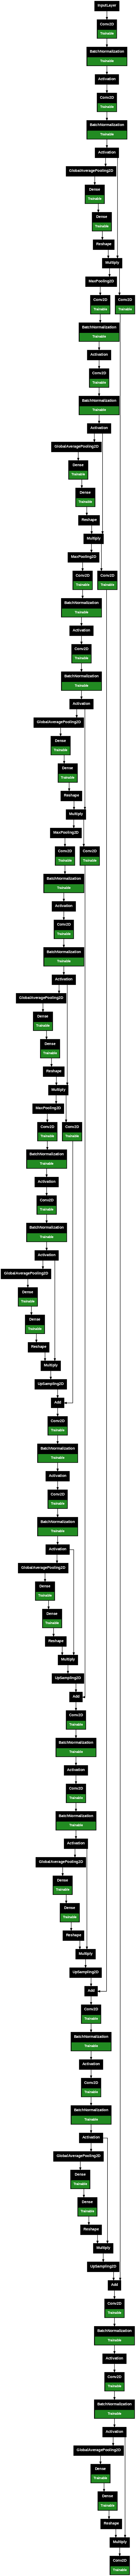

In [ ]:
model = build_unet_model()

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(
    loss=weighted_loss,
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=[mean_iou])

#model.summary()

tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# 🏋🏻 Train the model

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Dynamic learning rate
redurce_learning_rate = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_io_u', factor=0.1, patience=10, min_delta=1e-4, min_lr=1e-4)

# prompt: create a visualization callback that shoows the validation image at index 0, its output and its expected output, every 5 epochs
def visualize_callback(epoch, logs):
    if epoch % 5 == 0:
        # Select a random validation image
        index = 3  # Use index 0 for the first validation image
        val_image = X_val[index]
        val_label = y_val[index]

        # Predict the output for the selected image
        predicted_output = model.predict(np.expand_dims(val_image, axis=0))
        predicted_class = np.argmax(predicted_output[0], axis=-1)

        # Plot the image, predicted output, and expected output
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(val_image[:, :, 0])
        plt.title(f"Validation Image (Index: {index})")

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_class)
        plt.title("Predicted Output")

        plt.subplot(1, 3, 3)
        plt.imshow(val_label)
        plt.title("Expected Output")


        plt.show()

visualize = tfk.callbacks.LambdaCallback(on_epoch_end=visualize_callback)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


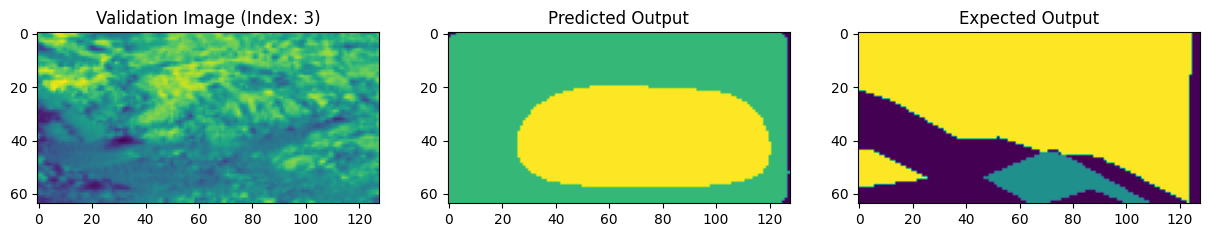

126/126 ━━━━━━━━━━━━━━━━━━━━ 84s 330ms/step - loss: 1.2076 - mean_io_u: 0.1706 - val_loss: 2.1644 - val_mean_io_u: 0.0522 - learning_rate: 0.0010
Epoch 2/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 0.9252 - mean_io_u: 0.3087 - val_loss: 2.8885 - val_mean_io_u: 0.0658 - learning_rate: 0.0010
Epoch 3/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.8622 - mean_io_u: 0.3315 - val_loss: 2.1664 - val_mean_io_u: 0.0675 - learning_rate: 0.0010
Epoch 4/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.7677 - mean_io_u: 0.3800 - val_loss: 1.8192 - val_mean_io_u: 0.1767 - learning_rate: 0.0010
Epoch 5/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.6848 - mean_io_u: 0.4205 - val_loss: 1.3875 - val_mean_io_u: 0.2572 - learning_rate: 0.0010
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


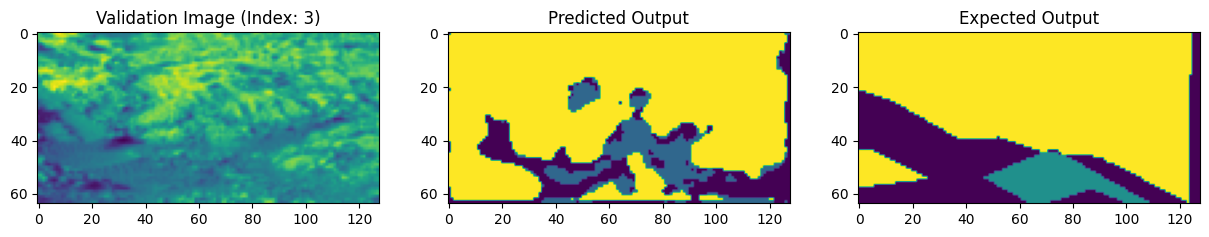

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.7558 - mean_io_u: 0.3696 - val_loss: 1.1679 - val_mean_io_u: 0.1929 - learning_rate: 0.0010
Epoch 7/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.6796 - mean_io_u: 0.4170 - val_loss: 0.9018 - val_mean_io_u: 0.2826 - learning_rate: 0.0010
Epoch 8/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.6564 - mean_io_u: 0.4250 - val_loss: 0.6394 - val_mean_io_u: 0.4122 - learning_rate: 0.0010
Epoch 9/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.6018 - mean_io_u: 0.4459 - val_loss: 0.8298 - val_mean_io_u: 0.3407 - learning_rate: 0.0010
Epoch 10/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.6084 - mean_io_u: 0.4501 - val_loss: 0.6976 - val_mean_io_u: 0.3667 - learning_rate: 0.0010
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


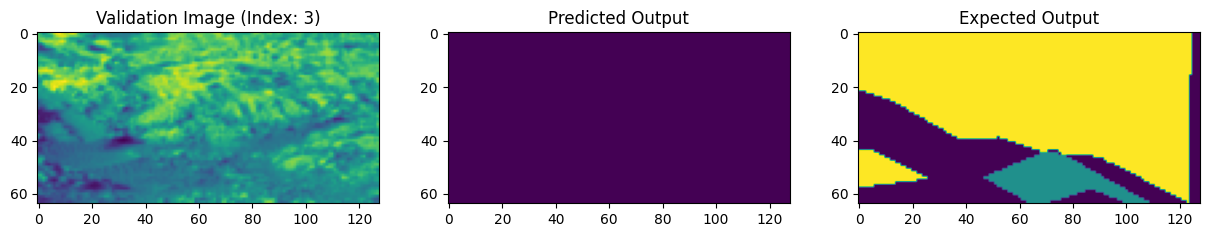

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.5878 - mean_io_u: 0.4691 - val_loss: 1.1987 - val_mean_io_u: 0.1776 - learning_rate: 0.0010
Epoch 12/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.5323 - mean_io_u: 0.4907 - val_loss: 0.4263 - val_mean_io_u: 0.5461 - learning_rate: 1.0000e-04
Epoch 13/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.4921 - mean_io_u: 0.5137 - val_loss: 0.4114 - val_mean_io_u: 0.5600 - learning_rate: 1.0000e-04
Epoch 14/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.4754 - mean_io_u: 0.5204 - val_loss: 0.4066 - val_mean_io_u: 0.5612 - learning_rate: 1.0000e-04
Epoch 15/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.4648 - mean_io_u: 0.5234 - val_loss: 0.4014 - val_mean_io_u: 0.5630 - learning_rate: 1.0000e-04
Epoch 16/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


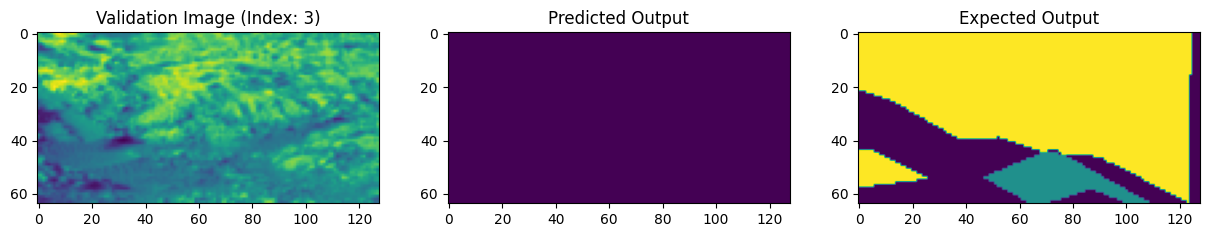

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.4562 - mean_io_u: 0.5245 - val_loss: 0.3917 - val_mean_io_u: 0.5661 - learning_rate: 1.0000e-04
Epoch 17/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.4484 - mean_io_u: 0.5256 - val_loss: 0.3909 - val_mean_io_u: 0.5640 - learning_rate: 1.0000e-04
Epoch 18/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.4406 - mean_io_u: 0.5271 - val_loss: 0.3856 - val_mean_io_u: 0.5664 - learning_rate: 1.0000e-04
Epoch 19/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.4324 - mean_io_u: 0.5294 - val_loss: 0.3793 - val_mean_io_u: 0.5738 - learning_rate: 1.0000e-04
Epoch 20/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.4241 - mean_io_u: 0.5317 - val_loss: 0.3680 - val_mean_io_u: 0.5748 - learning_rate: 1.0000e-04
Epoch 21/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


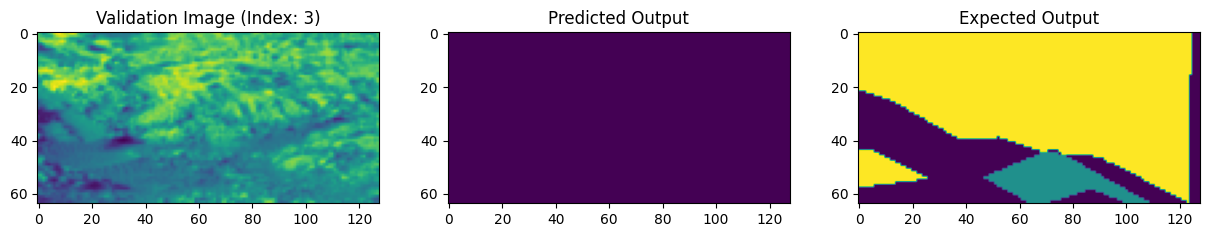

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.4164 - mean_io_u: 0.5347 - val_loss: 0.3663 - val_mean_io_u: 0.5767 - learning_rate: 1.0000e-04
Epoch 22/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.4076 - mean_io_u: 0.5377 - val_loss: 0.3658 - val_mean_io_u: 0.5786 - learning_rate: 1.0000e-04
Epoch 23/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3984 - mean_io_u: 0.5411 - val_loss: 0.3687 - val_mean_io_u: 0.5847 - learning_rate: 1.0000e-04
Epoch 24/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.3880 - mean_io_u: 0.5438 - val_loss: 0.3600 - val_mean_io_u: 0.5777 - learning_rate: 1.0000e-04
Epoch 25/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.3781 - mean_io_u: 0.5467 - val_loss: 0.3719 - val_mean_io_u: 0.5706 - learning_rate: 1.0000e-04
Epoch 26/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


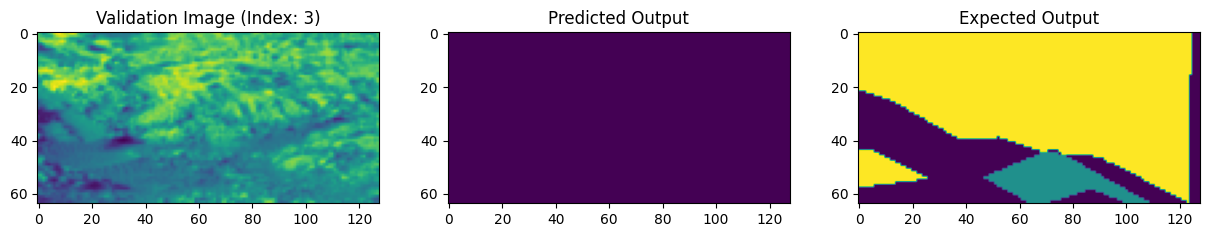

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.3690 - mean_io_u: 0.5488 - val_loss: 0.3708 - val_mean_io_u: 0.5779 - learning_rate: 1.0000e-04
Epoch 27/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3603 - mean_io_u: 0.5519 - val_loss: 0.3894 - val_mean_io_u: 0.5721 - learning_rate: 1.0000e-04
Epoch 28/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.3552 - mean_io_u: 0.5543 - val_loss: 0.3745 - val_mean_io_u: 0.5780 - learning_rate: 1.0000e-04
Epoch 29/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.3398 - mean_io_u: 0.5618 - val_loss: 0.3809 - val_mean_io_u: 0.5784 - learning_rate: 1.0000e-04
Epoch 30/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.3332 - mean_io_u: 0.5661 - val_loss: 0.3985 - val_mean_io_u: 0.5661 - learning_rate: 1.0000e-04
Epoch 31/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


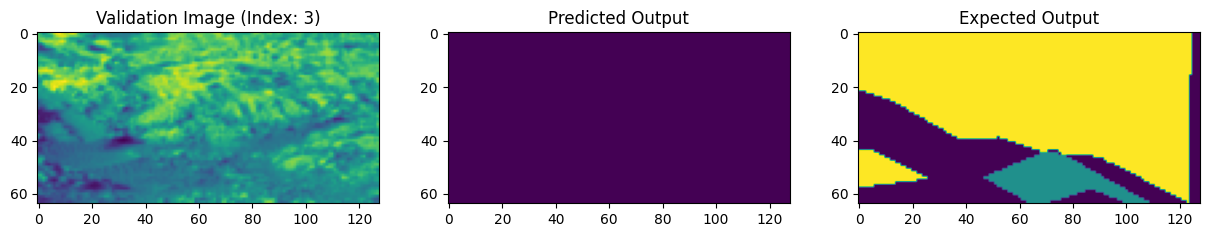

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.3393 - mean_io_u: 0.5637 - val_loss: 0.3625 - val_mean_io_u: 0.5802 - learning_rate: 1.0000e-04
Epoch 32/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3271 - mean_io_u: 0.5683 - val_loss: 0.3765 - val_mean_io_u: 0.5728 - learning_rate: 1.0000e-04
Epoch 33/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.3238 - mean_io_u: 0.5670 - val_loss: 0.3655 - val_mean_io_u: 0.5849 - learning_rate: 1.0000e-04
Epoch 34/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.3079 - mean_io_u: 0.5796 - val_loss: 0.3600 - val_mean_io_u: 0.5925 - learning_rate: 1.0000e-04
Epoch 35/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2958 - mean_io_u: 0.5890 - val_loss: 0.3620 - val_mean_io_u: 0.5902 - learning_rate: 1.0000e-04
Epoch 36/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


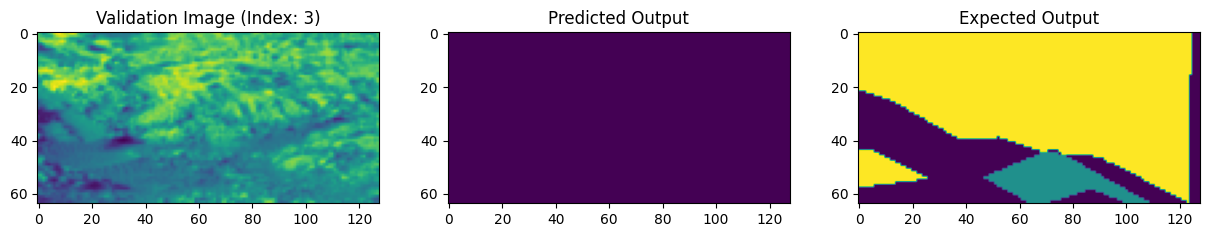

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.2894 - mean_io_u: 0.5947 - val_loss: 0.3671 - val_mean_io_u: 0.5819 - learning_rate: 1.0000e-04
Epoch 37/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2840 - mean_io_u: 0.5983 - val_loss: 0.3802 - val_mean_io_u: 0.5857 - learning_rate: 1.0000e-04
Epoch 38/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.2815 - mean_io_u: 0.5990 - val_loss: 0.3910 - val_mean_io_u: 0.5699 - learning_rate: 1.0000e-04
Epoch 39/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.3194 - mean_io_u: 0.5797 - val_loss: 0.4095 - val_mean_io_u: 0.5619 - learning_rate: 1.0000e-04
Epoch 40/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.3164 - mean_io_u: 0.5704 - val_loss: 0.3640 - val_mean_io_u: 0.6042 - learning_rate: 1.0000e-04
Epoch 41/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


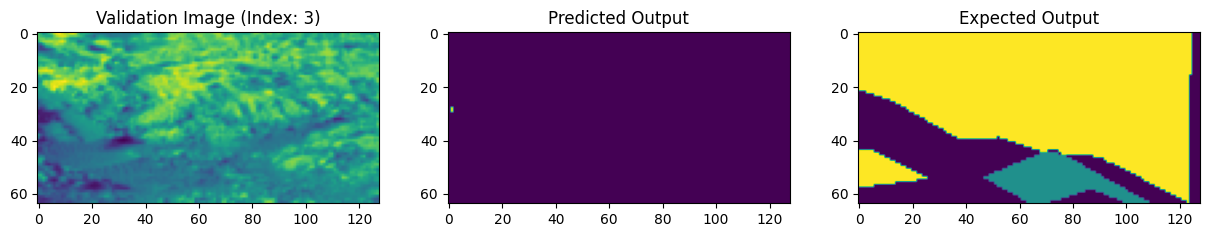

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.2814 - mean_io_u: 0.6000 - val_loss: 0.3878 - val_mean_io_u: 0.5962 - learning_rate: 1.0000e-04
Epoch 42/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.2680 - mean_io_u: 0.6096 - val_loss: 0.3620 - val_mean_io_u: 0.5995 - learning_rate: 1.0000e-04
Epoch 43/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.2579 - mean_io_u: 0.6170 - val_loss: 0.3641 - val_mean_io_u: 0.6029 - learning_rate: 1.0000e-04
Epoch 44/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.2524 - mean_io_u: 0.6223 - val_loss: 0.3649 - val_mean_io_u: 0.6043 - learning_rate: 1.0000e-04
Epoch 45/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.2463 - mean_io_u: 0.6287 - val_loss: 0.3635 - val_mean_io_u: 0.6048 - learning_rate: 1.0000e-04
Epoch 46/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


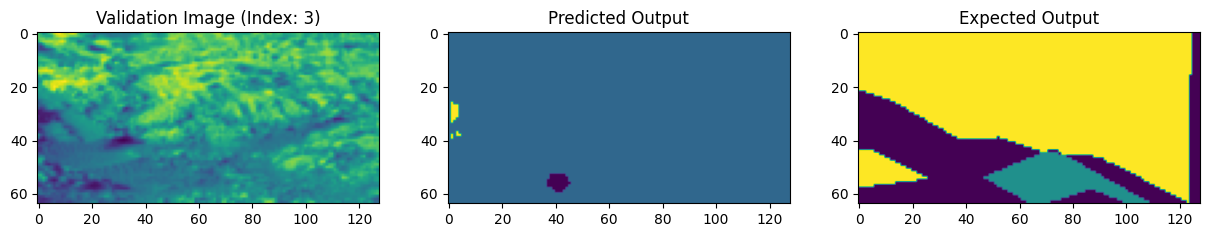

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.2404 - mean_io_u: 0.6349 - val_loss: 0.3597 - val_mean_io_u: 0.6072 - learning_rate: 1.0000e-04
Epoch 47/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.2346 - mean_io_u: 0.6424 - val_loss: 0.3732 - val_mean_io_u: 0.5924 - learning_rate: 1.0000e-04
Epoch 48/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.2292 - mean_io_u: 0.6481 - val_loss: 0.3660 - val_mean_io_u: 0.6108 - learning_rate: 1.0000e-04
Epoch 49/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.2232 - mean_io_u: 0.6557 - val_loss: 0.3642 - val_mean_io_u: 0.6154 - learning_rate: 1.0000e-04
Epoch 50/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2550 - mean_io_u: 0.6267 - val_loss: 0.4846 - val_mean_io_u: 0.5525 - learning_rate: 1.0000e-04
Epoch 51/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


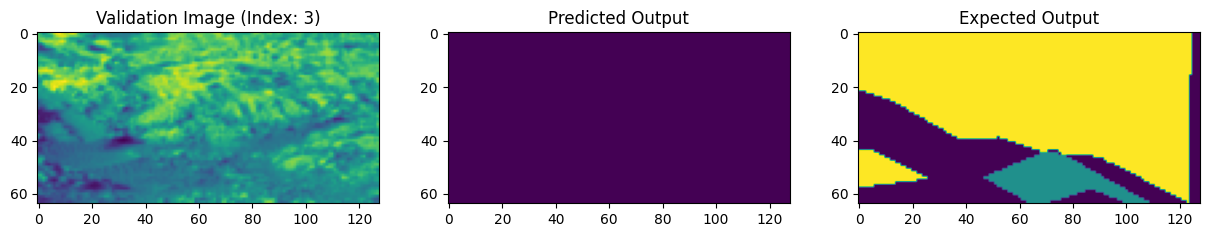

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.3130 - mean_io_u: 0.5827 - val_loss: 0.3597 - val_mean_io_u: 0.5972 - learning_rate: 1.0000e-04
Epoch 52/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.2348 - mean_io_u: 0.6309 - val_loss: 0.3481 - val_mean_io_u: 0.6008 - learning_rate: 1.0000e-04
Epoch 53/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.2111 - mean_io_u: 0.6561 - val_loss: 0.3590 - val_mean_io_u: 0.6068 - learning_rate: 1.0000e-04
Epoch 54/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.2057 - mean_io_u: 0.6646 - val_loss: 0.3426 - val_mean_io_u: 0.6027 - learning_rate: 1.0000e-04
Epoch 55/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.1990 - mean_io_u: 0.6701 - val_loss: 0.3682 - val_mean_io_u: 0.6145 - learning_rate: 1.0000e-04
Epoch 56/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


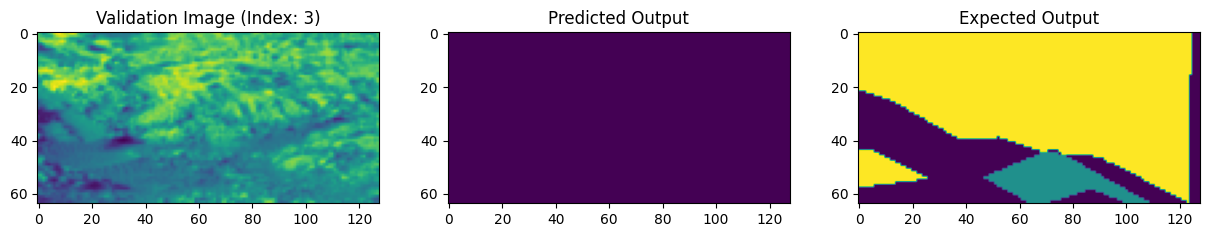

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.1947 - mean_io_u: 0.6753 - val_loss: 0.3652 - val_mean_io_u: 0.5899 - learning_rate: 1.0000e-04
Epoch 57/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.1898 - mean_io_u: 0.6770 - val_loss: 0.3708 - val_mean_io_u: 0.6190 - learning_rate: 1.0000e-04
Epoch 58/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1876 - mean_io_u: 0.6821 - val_loss: 0.3625 - val_mean_io_u: 0.5943 - learning_rate: 1.0000e-04
Epoch 59/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1803 - mean_io_u: 0.6870 - val_loss: 0.3843 - val_mean_io_u: 0.5938 - learning_rate: 1.0000e-04
Epoch 60/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.2182 - mean_io_u: 0.6523 - val_loss: 0.5127 - val_mean_io_u: 0.5610 - learning_rate: 1.0000e-04
Epoch 61/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


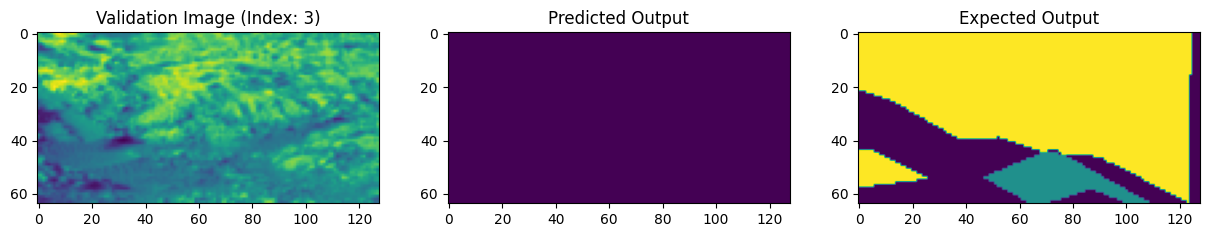

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.1922 - mean_io_u: 0.6652 - val_loss: 0.3793 - val_mean_io_u: 0.6035 - learning_rate: 1.0000e-04
Epoch 62/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1835 - mean_io_u: 0.6723 - val_loss: 0.3881 - val_mean_io_u: 0.6155 - learning_rate: 1.0000e-04
Epoch 63/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1764 - mean_io_u: 0.6897 - val_loss: 0.3681 - val_mean_io_u: 0.6043 - learning_rate: 1.0000e-04
Epoch 64/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1603 - mean_io_u: 0.7050 - val_loss: 0.3930 - val_mean_io_u: 0.5958 - learning_rate: 1.0000e-04
Epoch 65/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1765 - mean_io_u: 0.6786 - val_loss: 0.4200 - val_mean_io_u: 0.5961 - learning_rate: 1.0000e-04
Epoch 66/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


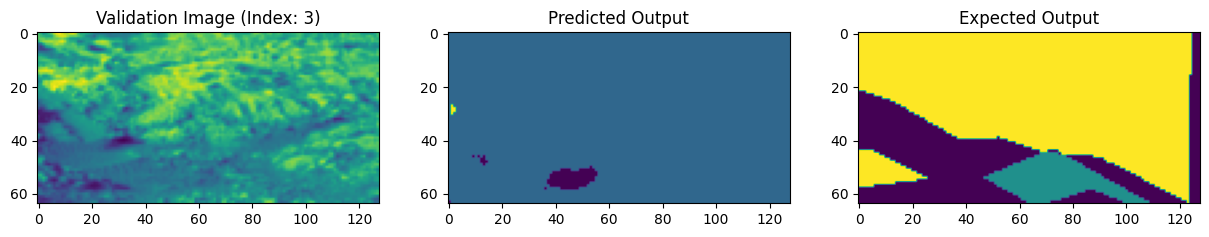

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.1680 - mean_io_u: 0.6865 - val_loss: 0.3983 - val_mean_io_u: 0.6066 - learning_rate: 1.0000e-04
Epoch 67/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1551 - mean_io_u: 0.7120 - val_loss: 0.4105 - val_mean_io_u: 0.6205 - learning_rate: 1.0000e-04
Epoch 68/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.1465 - mean_io_u: 0.7247 - val_loss: 0.4446 - val_mean_io_u: 0.6146 - learning_rate: 1.0000e-04
Epoch 69/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.1474 - mean_io_u: 0.7241 - val_loss: 0.4742 - val_mean_io_u: 0.6261 - learning_rate: 1.0000e-04
Epoch 70/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.1466 - mean_io_u: 0.7289 - val_loss: 0.4460 - val_mean_io_u: 0.6359 - learning_rate: 1.0000e-04
Epoch 71/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


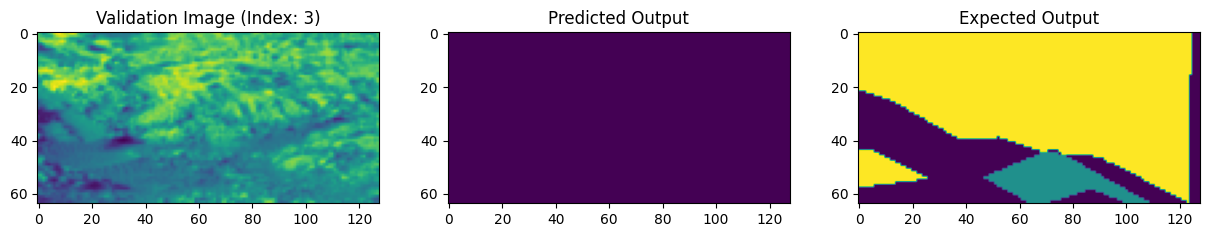

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.1316 - mean_io_u: 0.7550 - val_loss: 0.4797 - val_mean_io_u: 0.6273 - learning_rate: 1.0000e-04
Epoch 72/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1359 - mean_io_u: 0.7409 - val_loss: 0.4696 - val_mean_io_u: 0.6209 - learning_rate: 1.0000e-04
Epoch 73/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1729 - mean_io_u: 0.6977 - val_loss: 0.8212 - val_mean_io_u: 0.4773 - learning_rate: 1.0000e-04
Epoch 74/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.2975 - mean_io_u: 0.6113 - val_loss: 0.4681 - val_mean_io_u: 0.5663 - learning_rate: 1.0000e-04
Epoch 75/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.2529 - mean_io_u: 0.6193 - val_loss: 0.3910 - val_mean_io_u: 0.5815 - learning_rate: 1.0000e-04
Epoch 76/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


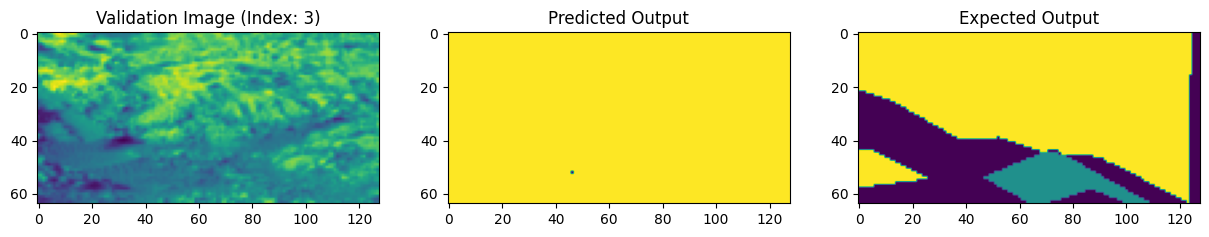

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.1593 - mean_io_u: 0.6850 - val_loss: 0.4029 - val_mean_io_u: 0.6032 - learning_rate: 1.0000e-04
Epoch 77/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1376 - mean_io_u: 0.7139 - val_loss: 0.4169 - val_mean_io_u: 0.6023 - learning_rate: 1.0000e-04
Epoch 78/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1278 - mean_io_u: 0.7315 - val_loss: 0.4338 - val_mean_io_u: 0.6036 - learning_rate: 1.0000e-04
Epoch 79/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.1201 - mean_io_u: 0.7450 - val_loss: 0.4647 - val_mean_io_u: 0.6022 - learning_rate: 1.0000e-04
Epoch 80/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1147 - mean_io_u: 0.7526 - val_loss: 0.4887 - val_mean_io_u: 0.6049 - learning_rate: 1.0000e-04
Epoch 81/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


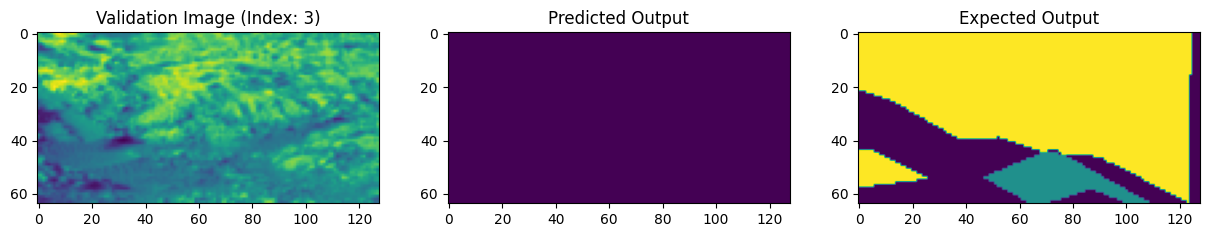

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.1129 - mean_io_u: 0.7566 - val_loss: 0.4668 - val_mean_io_u: 0.6078 - learning_rate: 1.0000e-04
Epoch 82/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1069 - mean_io_u: 0.7706 - val_loss: 0.4976 - val_mean_io_u: 0.6061 - learning_rate: 1.0000e-04
Epoch 83/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1038 - mean_io_u: 0.7759 - val_loss: 0.5357 - val_mean_io_u: 0.6091 - learning_rate: 1.0000e-04
Epoch 84/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.1011 - mean_io_u: 0.7785 - val_loss: 0.5346 - val_mean_io_u: 0.5797 - learning_rate: 1.0000e-04
Epoch 85/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.1504 - mean_io_u: 0.6966 - val_loss: 0.4694 - val_mean_io_u: 0.5807 - learning_rate: 1.0000e-04
Epoch 86/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


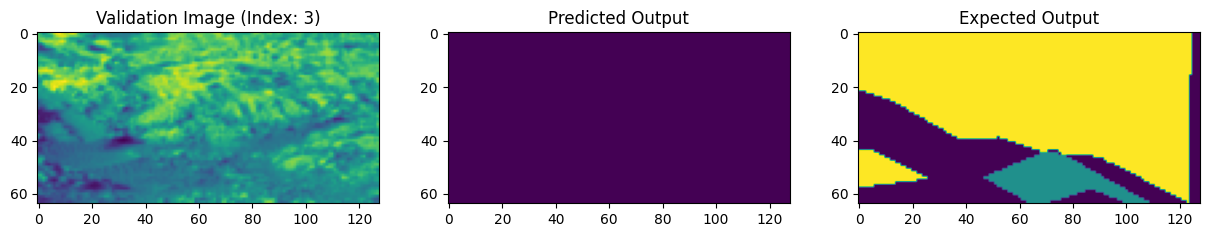

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.1110 - mean_io_u: 0.7558 - val_loss: 0.4709 - val_mean_io_u: 0.6115 - learning_rate: 1.0000e-04
Epoch 87/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.1003 - mean_io_u: 0.7771 - val_loss: 0.5021 - val_mean_io_u: 0.6094 - learning_rate: 1.0000e-04
Epoch 88/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0925 - mean_io_u: 0.7834 - val_loss: 0.5392 - val_mean_io_u: 0.6009 - learning_rate: 1.0000e-04
Epoch 89/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0928 - mean_io_u: 0.7814 - val_loss: 0.5496 - val_mean_io_u: 0.6167 - learning_rate: 1.0000e-04
Epoch 90/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0923 - mean_io_u: 0.7944 - val_loss: 0.6242 - val_mean_io_u: 0.6111 - learning_rate: 1.0000e-04
Epoch 91/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


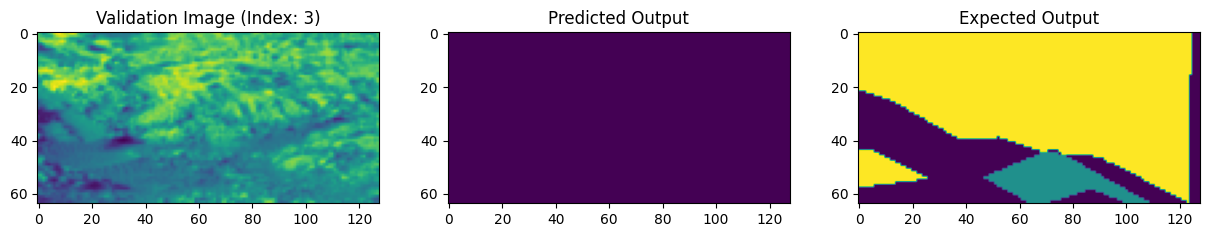

126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.1560 - mean_io_u: 0.7155 - val_loss: 0.6291 - val_mean_io_u: 0.5866 - learning_rate: 1.0000e-04
Epoch 92/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.1465 - mean_io_u: 0.7013 - val_loss: 0.4442 - val_mean_io_u: 0.6169 - learning_rate: 1.0000e-04
Epoch 93/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1020 - mean_io_u: 0.7601 - val_loss: 0.4574 - val_mean_io_u: 0.6117 - learning_rate: 1.0000e-04
Epoch 94/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0916 - mean_io_u: 0.8005 - val_loss: 0.4892 - val_mean_io_u: 0.6064 - learning_rate: 1.0000e-04
Epoch 95/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0860 - mean_io_u: 0.8146 - val_loss: 0.5084 - val_mean_io_u: 0.6042 - learning_rate: 1.0000e-04
Epoch 96/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


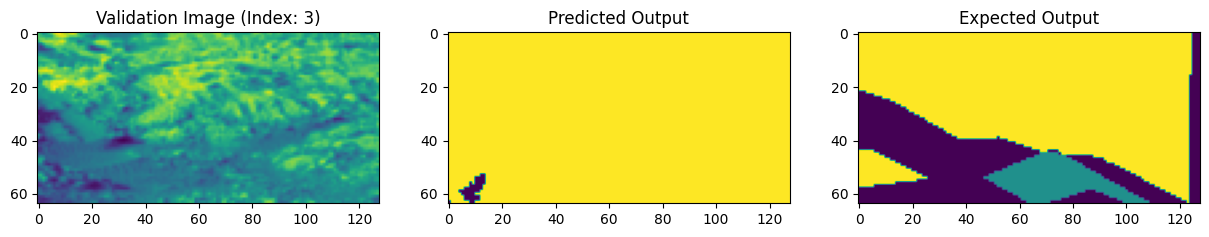

126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0822 - mean_io_u: 0.8222 - val_loss: 0.5351 - val_mean_io_u: 0.6070 - learning_rate: 1.0000e-04
Epoch 97/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0830 - mean_io_u: 0.8214 - val_loss: 0.5268 - val_mean_io_u: 0.5990 - learning_rate: 1.0000e-04
Epoch 98/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0780 - mean_io_u: 0.8297 - val_loss: 0.5702 - val_mean_io_u: 0.6084 - learning_rate: 1.0000e-04
Epoch 99/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0794 - mean_io_u: 0.8197 - val_loss: 0.5174 - val_mean_io_u: 0.6125 - learning_rate: 1.0000e-04
Epoch 100/500
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0851 - mean_io_u: 0.7784 - val_loss: 0.5477 - val_mean_io_u: 0.5897 - learning_rate: 1.0000e-04
Final validation Mean Intersection Over Union: 63.59%


In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, redurce_learning_rate, visualize],

).history

# Calculate and print the final validation mean IoU
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# 🛟 Save the model

In [ ]:
if KAGGLE == 0:
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2/OverFritti/Batu

model_filename = f"weights.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

/gdrive/.shortcut-targets-by-id/1VBkyG65Jpi0yRdsCuQISuNxt9jB7HRfA/OverFritti/Batu
Model saved to weights.keras


# 📈 Plot loss and mean IoU

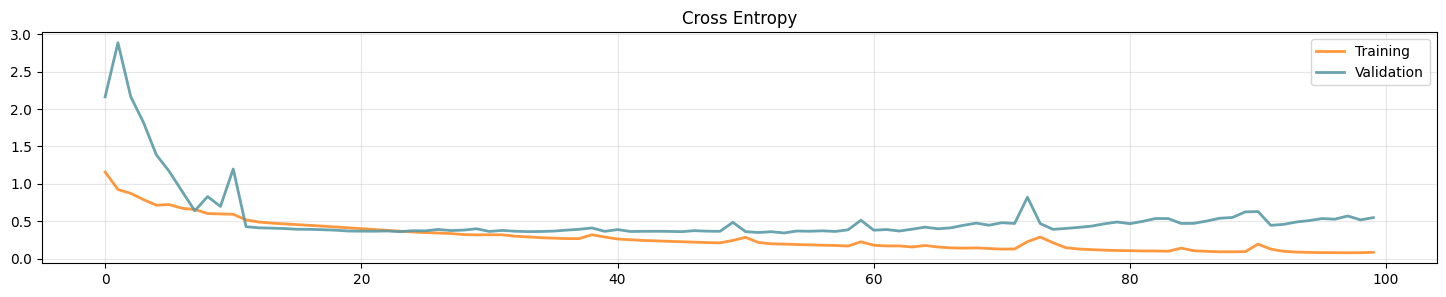

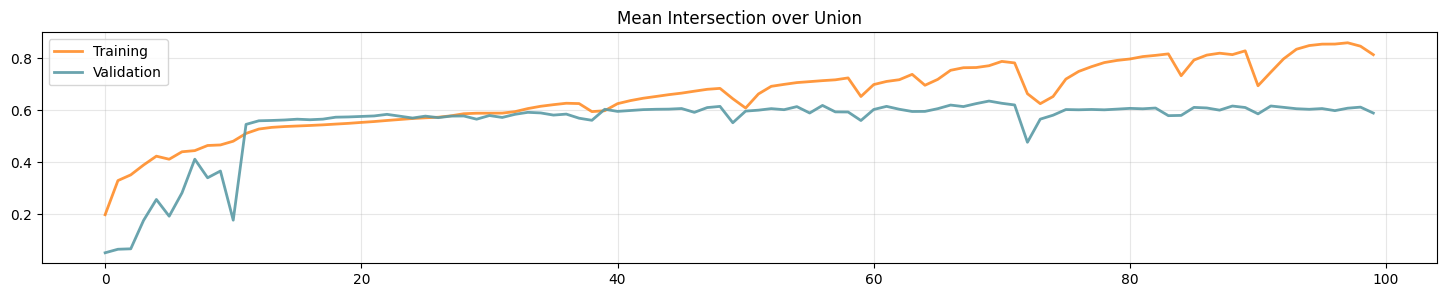

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()